In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
# Base Libraries
import pandas as pd
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
# Classifier
from sklearn.linear_model import LogisticRegression
# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
                                    train_test_split,
                                    TimeSeriesSplit
                                    )
# Metrics
from sklearn.metrics import (
                            accuracy_score,
                            classification_report,
                            RocCurveDisplay,
                            ConfusionMatrixDisplay,
                            log_loss
                            )

In [2]:
df = pd.read_csv('data/niftyindex.csv', index_col=0, parse_dates=True, dayfirst=True)
df.head(2)

Open     High      Low    Close     Volume
2012-01-02  4640.2  4645.95  4588.05  4636.75  108461000
2012-01-03  4675.8  4773.10  4675.80  4765.30  146621008

In [3]:
# Get Info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2719 entries, 2012-01-02 to 2022-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2719 non-null   float64
 1   High    2719 non-null   float64
 2   Low     2719 non-null   float64
 3   Close   2719 non-null   float64
 4   Volume  2719 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 127.5 KB


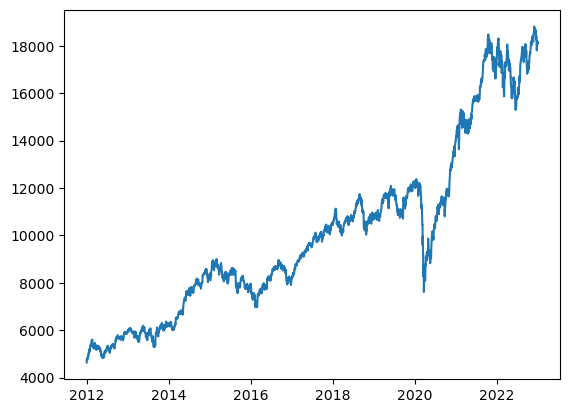

In [4]:
# Visualize data
plt.plot(df['Close']);

In [5]:
# Descriptive statistics
df.describe().T

count          mean           std         min           25%  \
Open    2719.0  1.012490e+04  3.709607e+03     4640.20  7.637000e+03   
High    2719.0  1.017529e+04  3.725527e+03     4645.95  7.681000e+03   
Low     2719.0  1.005747e+04  3.685305e+03     4588.05  7.581650e+03   
Close   2719.0  1.011757e+04  3.706945e+03     4636.75  7.623800e+03   
Volume  2719.0  2.892221e+08  1.952768e+08  2826000.00  1.591780e+08   

                 50%           75%           max  
Open    9.376950e+03  1.170085e+04  1.887195e+04  
High    9.431900e+03  1.175512e+04  1.888760e+04  
Low     9.301350e+03  1.163133e+04  1.877820e+04  
Close   9.351850e+03  1.168400e+04  1.881250e+04  
Volume  2.194961e+08  3.409088e+08  1.810971e+09

In [6]:
# Check for missing values
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [7]:
# Create Features
df['HC'] = df['High'] - df['Close']
df['RET'] = np.log(df['Close'] / df['Close'].shift(1))
df['MA7'] = df['Close'] / df['Close'].rolling(7).mean()
df['VMA'] = df['Volume'] / df['Volume'].rolling(7).mean()
df['OC_'] = df['Close'] / df['Open'] - 1
df['OC'] = df['OC_'].rolling(7).mean()
df['OC'] = df['OC_'].rolling(14).mean()
df['HC_'] = df['High'] / df['Low'] - 1
df['HC'] = df['HC_'].rolling(7).mean()
df['GAP_'] = df['Open'] / df['Close'].shift(1) - 1
df['GAP'] = df['GAP_'].rolling(7).mean()
df['STD'] = df['RET'].rolling(7).std()
df['UB'] = df['Close'].rolling(7).mean() + df['Close'].rolling(7).std() * 2
df.dropna(inplace=True)

features = df.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'OC_', 'HC_', 'GAP_'], axis=1)
features.head(2)

HC       RET       MA7       VMA        OC       GAP  \
2012-01-19  0.010942  0.012553  1.021970  1.002220  0.003754  0.002402   
2012-01-20  0.011600  0.006000  1.022538  1.079615  0.003860  0.002754   

                 STD           UB  
2012-01-19  0.008689  5049.501848  
2012-01-20  0.008620  5101.753784

In [8]:
# Specific X
X = features.values

In [9]:
# Specify y
y = np.where(df['Close'].shift(-1)>0.995*df['Close'],1,0)

In [10]:
# Check Class Imbalance
pd.Series(y).value_counts()

1    2060
0     646
dtype: int64

In [11]:
# Split the Data into Training and Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [12]:
# Define a Baseline Model
classifier = Pipeline([
        ("scaler", StandardScaler()),
        ("classifier", LogisticRegression(class_weight='balanced'))
    ])
classifier.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression(class_weight='balanced'))])

In [13]:
# Verify Class Labels
classifier.classes_

array([0, 1])

In [14]:
# Predict the Class Labels
y_pred = classifier.predict(X_test)
y_pred[-20:]

array([1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0])

In [15]:
# Predict Probabilities
y_proba = classifier.predict_proba(X_test)
y_proba[-20:]

array([[0.47572869, 0.52427131],
       [0.51508905, 0.48491095],
       [0.51766003, 0.48233997],
       [0.48961155, 0.51038845],
       [0.51685742, 0.48314258],
       [0.51268726, 0.48731274],
       [0.47859968, 0.52140032],
       [0.466398  , 0.533602  ],
       [0.53363852, 0.46636148],
       [0.49277066, 0.50722934],
       [0.49286965, 0.50713035],
       [0.51598902, 0.48401098],
       [0.54188298, 0.45811702],
       [0.53632059, 0.46367941],
       [0.59113072, 0.40886928],
       [0.50656508, 0.49343492],
       [0.48208138, 0.51791862],
       [0.51406554, 0.48593446],
       [0.45964397, 0.54035603],
       [0.52660768, 0.47339232]])

In [16]:
# Get the Scores
acc_train = accuracy_score(y_train, classifier.fit(X_train, y_train).predict(X_train))
acc_test = accuracy_score(y_test, classifier.predict(X_test))
print(f'Baseline Model -- Train Accuracy: {acc_train:0.4}, Test Accuracy: {acc_test:0.4}')

Baseline Model -- Train Accuracy: 0.5638, Test Accuracy: 0.6015


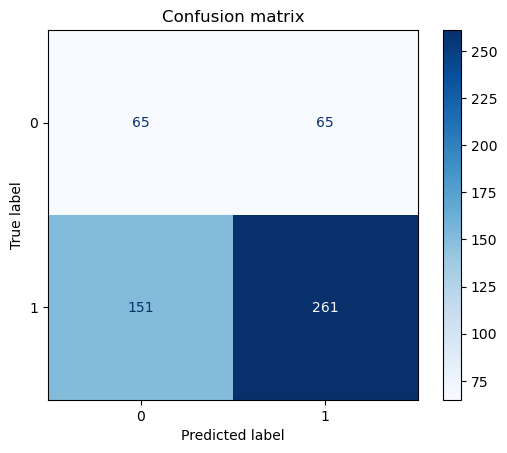

In [17]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        # display_labels=model.classes_,
        cmap=plt.cm.Blues
        )
plt.title('Confusion matrix')
plt.show()

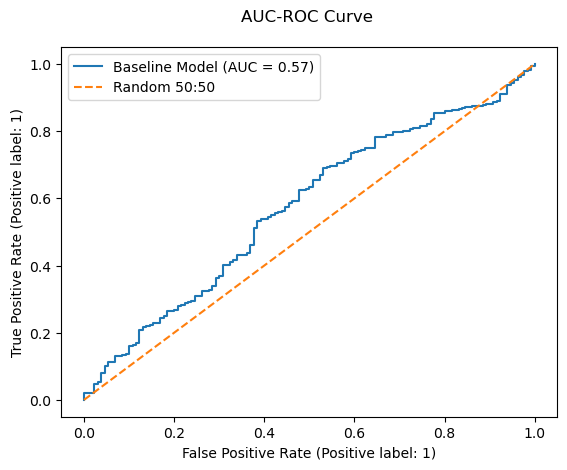

In [18]:
# Display ROCCurve
disp = RocCurveDisplay.from_estimator(
            classifier,
            X_test,
            y_test,
            name='Baseline Model')
plt.title("AUC-ROC Curve \n")
plt.plot([0,1],[0,1],linestyle="--", label='Random 50:50')
plt.legend()
plt.show()

In [19]:
# Classification Report
print(classification_report(y_test, classifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.30      0.50      0.38       130
           1       0.80      0.63      0.71       412

    accuracy                           0.60       542
   macro avg       0.55      0.57      0.54       542
weighted avg       0.68      0.60      0.63       542



In [20]:
# Get Params list
classifier.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('classifier', LogisticRegression(class_weight='balanced'))],
 'verbose': False,
 'scaler': StandardScaler(),
 'classifier': LogisticRegression(class_weight='balanced'),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'classifier__C': 1.0,
 'classifier__class_weight': 'balanced',
 'classifier__dual': False,
 'classifier__fit_intercept': True,
 'classifier__intercept_scaling': 1,
 'classifier__l1_ratio': None,
 'classifier__max_iter': 100,
 'classifier__multi_class': 'auto',
 'classifier__n_jobs': None,
 'classifier__penalty': 'l2',
 'classifier__random_state': None,
 'classifier__solver': 'lbfgs',
 'classifier__tol': 0.0001,
 'classifier__verbose': 0,
 'classifier__warm_start': False}

In [21]:
# Use Optuna for Tuning
import optuna

In [22]:
# Define Objective Function
def optimize(trial, x, y):
    # specify params range
    tolerance = trial.suggest_float("tol", 0.001, 0.01, log=True)
    regularization = trial.suggest_float('C', 0.001, 1, log=True)
    
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(
            C=regularization,
            tol=tolerance,
            class_weight='balanced'))
    ])
    
    tscv = TimeSeriesSplit(n_splits=2, gap=1)
    ll = []
    
    for idx in tscv.split(x):
        train_idx, test_idx = idx[0], idx[1]
        xtrain = x[train_idx]
        ytrain = y[train_idx]
        xtest = x[test_idx]
        ytest = y[test_idx]
        model.fit(xtrain, ytrain)
        preds = model.predict(xtest)
        ll.append(log_loss(ytest, preds))
    return -1.0 * np.mean(ll)

In [23]:
# Create a Study
study = optuna.create_study(
    study_name='hp_lr',
    direction='minimize'
)

[I 2024-05-07 10:56:15,390] A new study created in memory with name: hp_lr


In [24]:
# Specify Optimization function
optimization_function = partial(optimize, x=X, y=y)
study.optimize(optimization_function, n_trials=20)

[I 2024-05-07 10:56:15,414] Trial 0 finished with value: -12.707186006362809 and parameters: {'tol': 0.006847581561679445, 'C': 0.9992390635568684}. Best is trial 0 with value: -12.707186006362809.
[I 2024-05-07 10:56:15,426] Trial 1 finished with value: -12.727165858574072 and parameters: {'tol': 0.007933901173044912, 'C': 0.014394684497039536}. Best is trial 1 with value: -12.727165858574072.
[I 2024-05-07 10:56:15,441] Trial 2 finished with value: -12.727165858574072 and parameters: {'tol': 0.0011664860398344441, 'C': 0.013049173267294363}. Best is trial 1 with value: -12.727165858574072.
[I 2024-05-07 10:56:15,457] Trial 3 finished with value: -12.587306893095239 and parameters: {'tol': 0.003611154609439613, 'C': 0.13893760178071324}. Best is trial 1 with value: -12.727165858574072.
[I 2024-05-07 10:56:15,473] Trial 4 finished with value: -12.62726659751776 and parameters: {'tol': 0.0026006790234524295, 'C': 0.05137322332134692}. Best is trial 1 with value: -12.727165858574072.
[I 

In [25]:
# Get the Best Params
print(f'Best Params: {study.best_params}, Best Value: {study.best_value}')

Best Params: {'tol': 0.0018988032673369645, 'C': 0.001163326168140669}, Best Value: -13.206682311644368


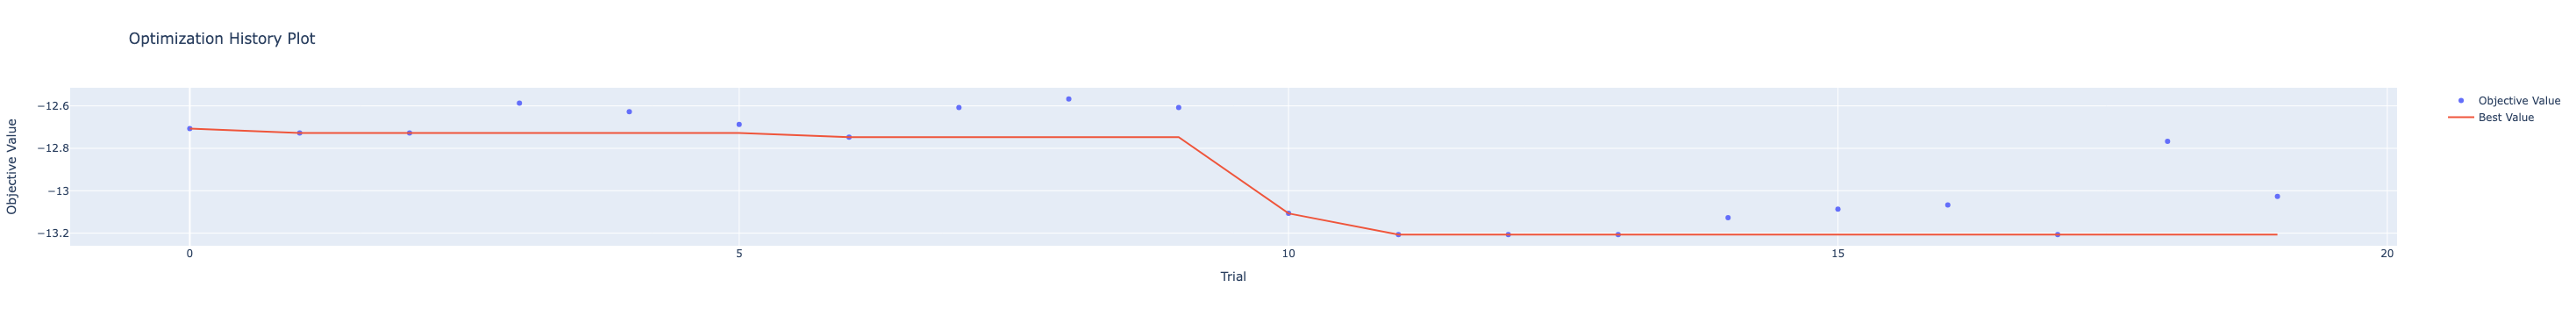

In [26]:
# plot Optimization History
optuna.visualization.plot_optimization_history(study)

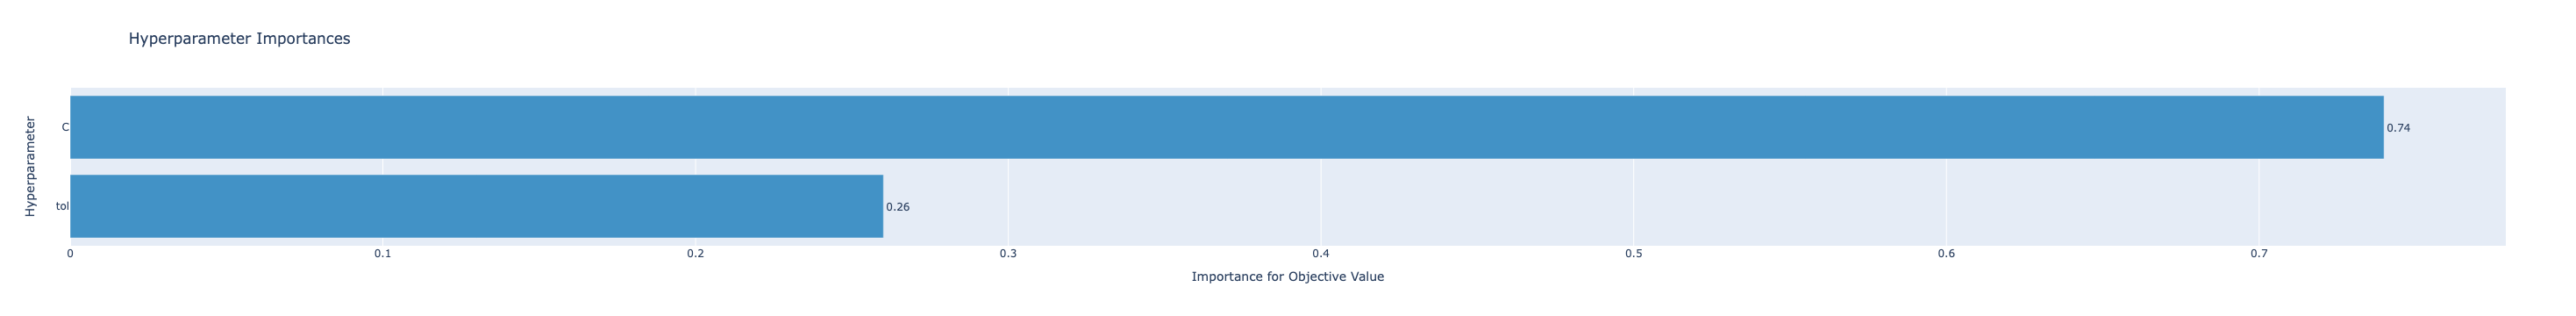

In [27]:
# Plot Param Importances
optuna.visualization.plot_param_importances(study)

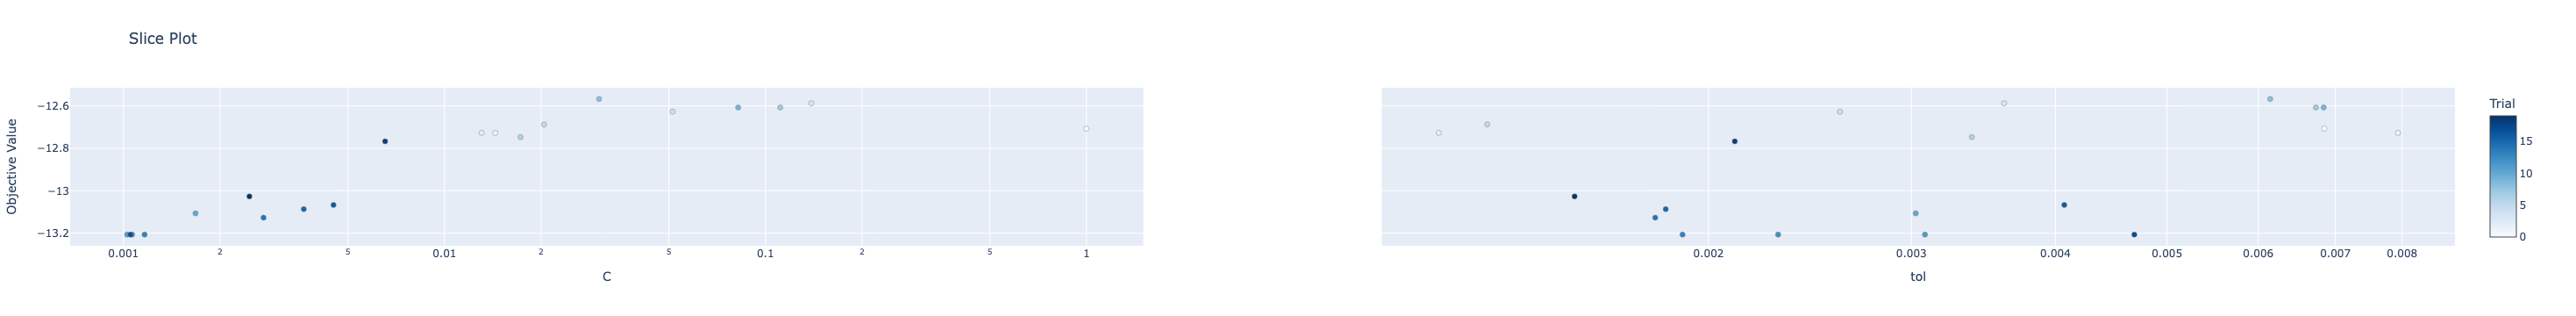

In [28]:
# plot accuracies for each HP trail
optuna.visualization.plot_slice(study)

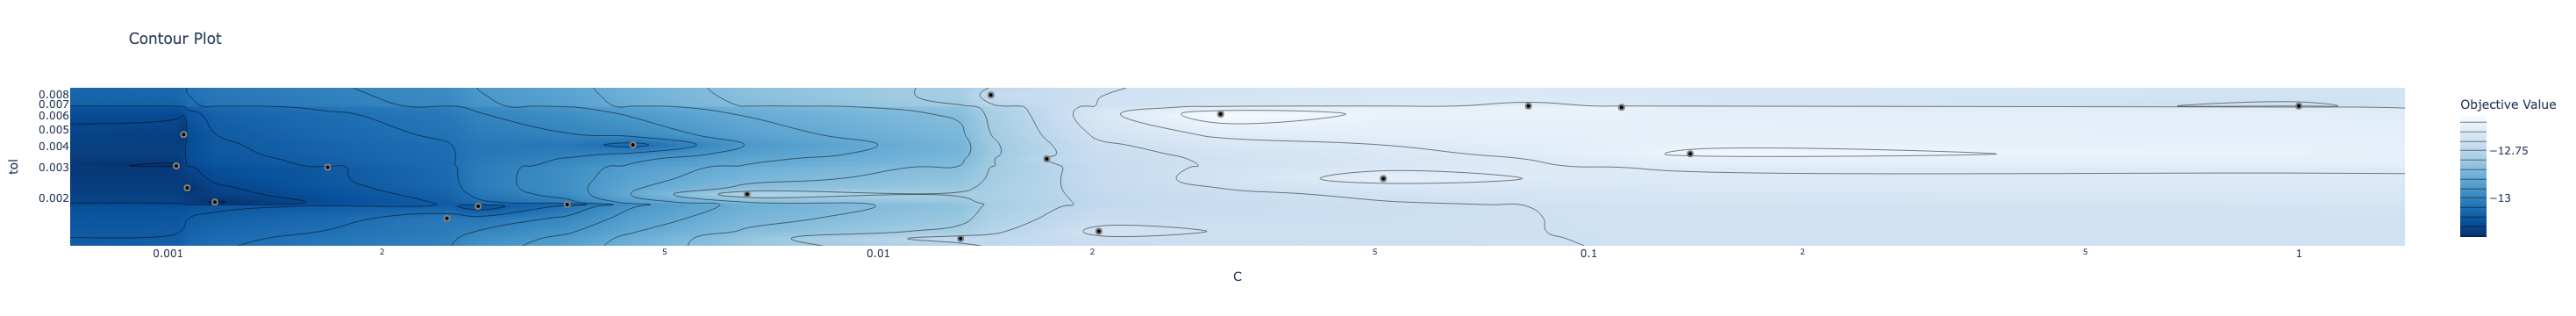

In [29]:
# plot the surface
optuna.visualization.plot_contour(study, params=['tol', 'C'])

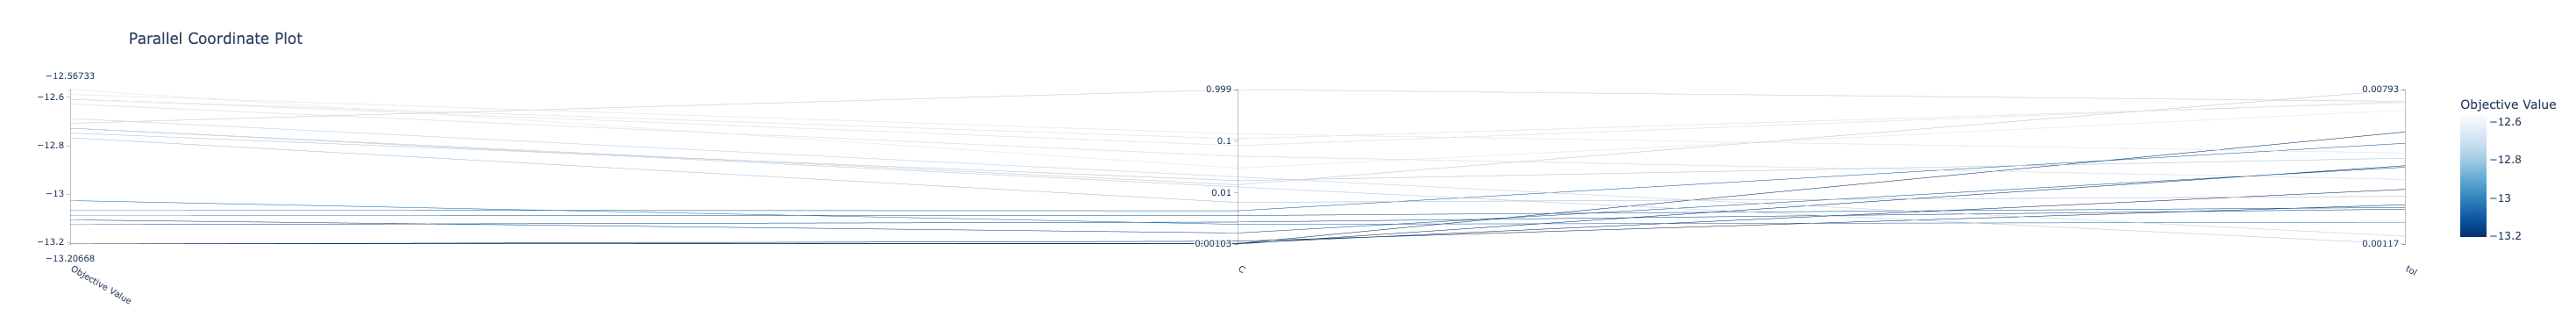

In [30]:
# plot parallel coordinates
optuna.visualization.plot_parallel_coordinate(study)

In [31]:
# Scale and fit the model
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("estimator", LogisticRegression(
        tol=study.best_params['tol'],
        C=study.best_params['C'],
        class_weight='balanced',
        ))
])

clf.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator',
                 LogisticRegression(C=0.001163326168140669,
                                    class_weight='balanced',
                                    tol=0.0018988032673369645))])

In [32]:
# Predict Class Labels
y_pred = clf.predict(X_test)

# Predict Probabilities for upside
# y_proba = model.best_estimator_.predict_proba(X_test)[:,1]

# Measure Accuracy
acc_train = accuracy_score(y_train, clf.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)

# Print Accuracy
print(f'\n Training Accuracy \t: {acc_train :0.4} \n Test Accuracy \t\t: {acc_test :0.4}')


 Training Accuracy 	: 0.5841 
 Test Accuracy 		: 0.6107


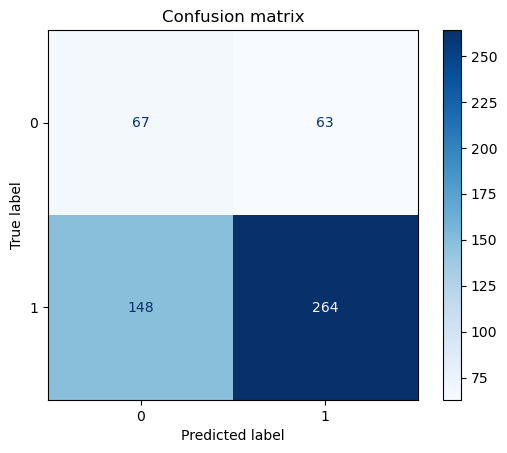

In [33]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        # display_labels=model.classes_,
        cmap=plt.cm.Blues
    )
plt.title('Confusion matrix')
plt.show()

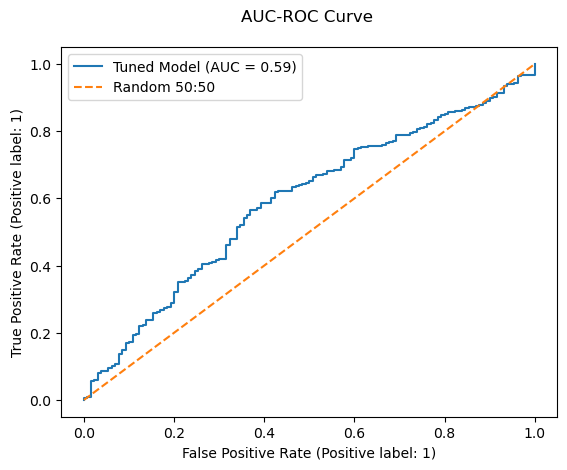

In [34]:
# Display ROCCurve
disp = RocCurveDisplay.from_estimator(
            clf,
            X_test,
            y_test,
            name='Tuned Model')
plt.title("AUC-ROC Curve \n")
plt.plot([0,1],[0,1],linestyle="--", label='Random 50:50')
plt.legend()
plt.show()

In [35]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.31      0.52      0.39       130
           1       0.81      0.64      0.71       412

    accuracy                           0.61       542
   macro avg       0.56      0.58      0.55       542
weighted avg       0.69      0.61      0.64       542



In [36]:
df2 = pd.read_csv('data/niftyindex.csv', index_col=0, parse_dates=True, dayfirst=True)
df2 = df2.iloc[13:,:]

# Get Prediction
df2['Signal'] = clf.predict(X)

# Define Entry Logic
df2['Entry'] = np.where(df2['Signal']==1, df2['Close'], 0)

# Defining Exit Logic
df2['Exit'] = np.where((df2['Entry'] != 0) & (df2['Open'].shift(-1) <= df2['Close']),
                         df['Open'].shift(-1), 0)
df2['Exit'] = np.where((df2['Entry'] != 0) & (df2['Open'].shift(-1) > df2['Close']),
                         df2['Close'].shift(-1), df2['Exit'])

# Calculate MTM
df2['P&L'] = df2['Exit'] - df2['Entry']

# Generate Equity Curve
df2['Equity'] = df2['P&L'].cumsum() + df2['Close'][0]

# Calculate Benchmark Return
df2['Returns'] = np.log(df2['Close']).diff().fillna(0)

# Calculate Strategy Return
df2['Strategy'] = (df2['Equity']/df2['Equity'].shift(1) - 1).fillna(0)
df2 = df2.iloc[:-1]

In [37]:
# Generate HTML Strategy Report
# Refer HTML file for report
import quantstats as qs

qs.reports.html(df2['Strategy'], df2['Returns'])

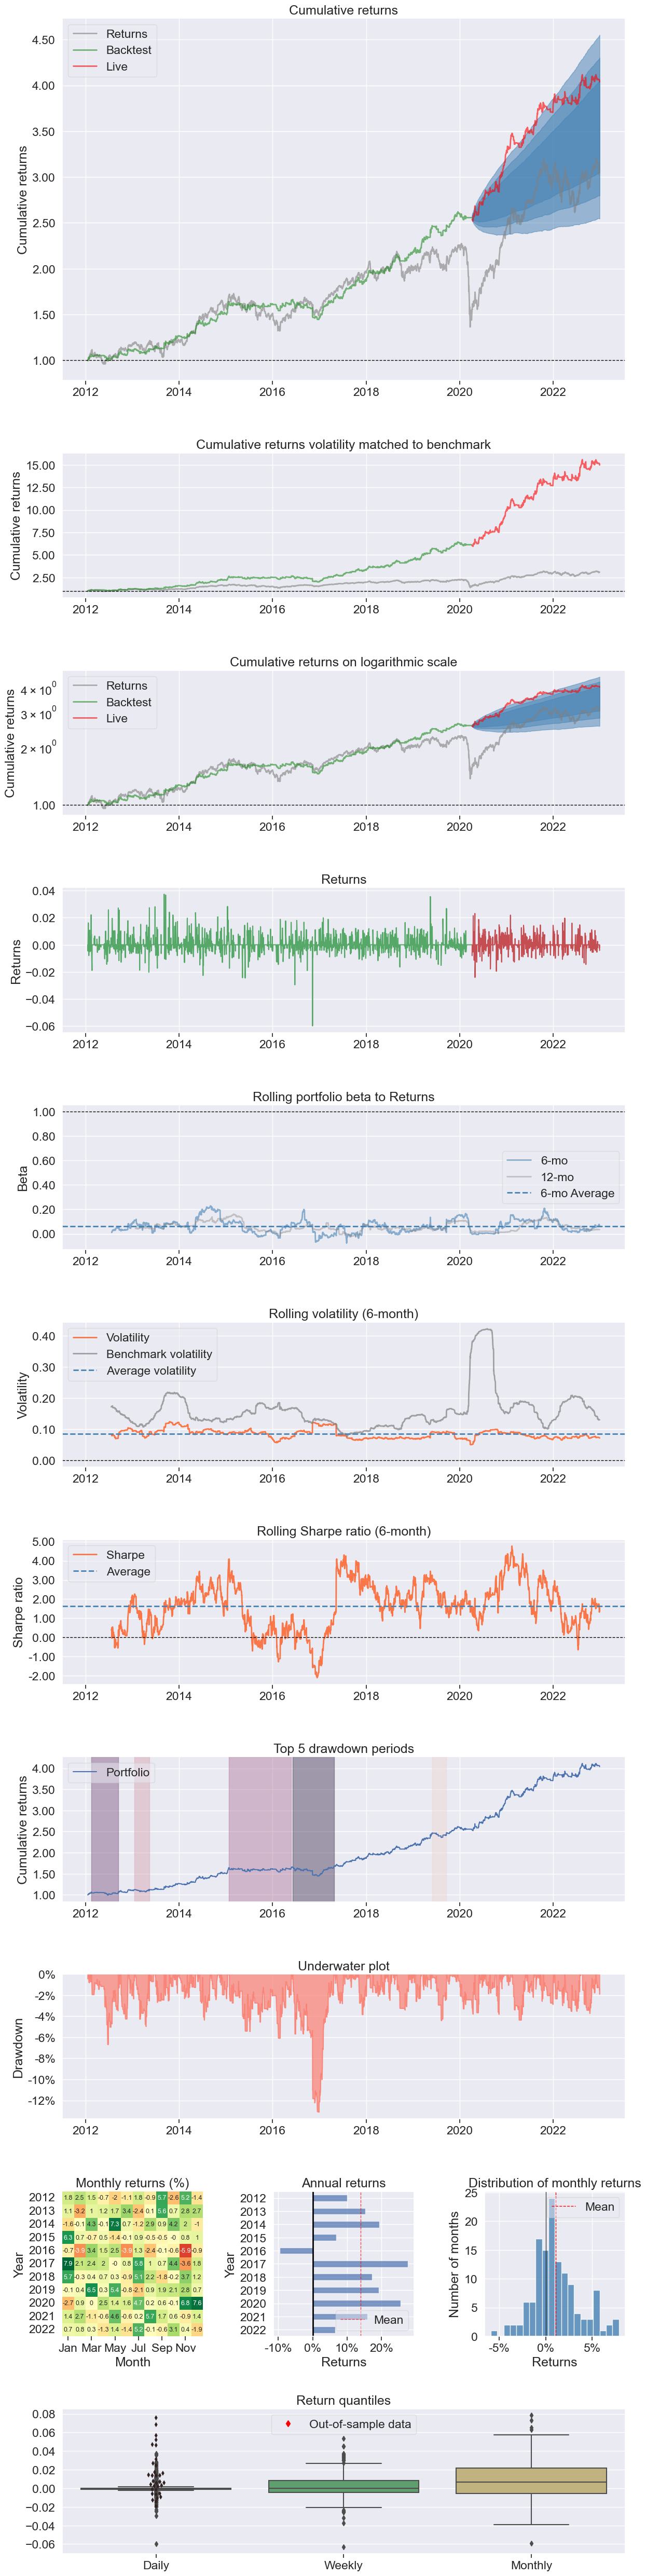

In [38]:
# Can also use pyfolio for analysis
import pyfolio as pf

df3 = df2.copy()
df3.index = df3.index.tz_localize('utc')
pf.create_returns_tear_sheet(df3['Strategy'], live_start_date='2020-04-07', benchmark_rets=df3['Returns'])